In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.10.0


In [2]:
#Dados de casas em Boston
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
dataset_path = keras.utils.get_file("housing.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data")

In [3]:
nomes_colunas = ['CRIM',
                 'ZN',
                 'INDUS',
                 'CHAS',
                 'NOX',
                 'RM', 
                 'AGE', 
                 'DIS',
                 'RAD',
                 'TAX',
                 'PTRATION', 
                 'B', 
                 'LSTAT', 
                 'MEDV']

#Carga dos dados
dataset = pd.read_csv(dataset_path, 
                      names = nomes_colunas,
                      na_values = "?", 
                      comment = '\t',
                      sep = " ", 
                      skipinitialspace = True)

In [4]:
#Partição dos dados
dados_treino = dataset.sample(frac = 0.8, random_state = 0)
dados_teste = dataset.drop(dados_treino.index)

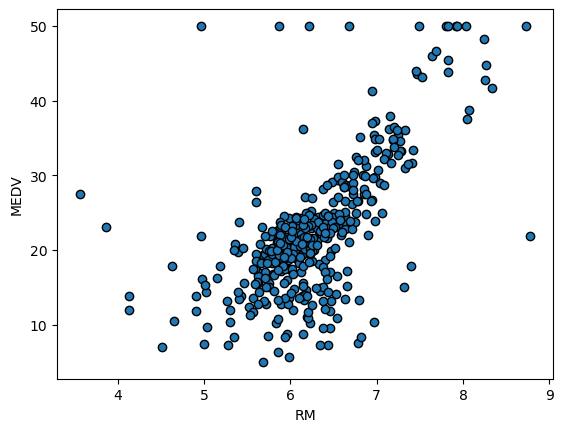

In [5]:
#Gráfico de dispersão
fig, ax = plt.subplots()
x = dados_treino['RM']
y = dados_treino['MEDV']
ax.scatter(x, y, edgecolors = (0, 0, 0))
ax.set_xlabel('RM')
ax.set_ylabel('MEDV')
plt.show()
# RM = média de quartos
# MEDV = mediana das casas ocupadas

In [6]:
#Separação de X e Y
x_treino = dados_treino['RM']
y_treino = dados_treino['MEDV']
x_teste = dados_teste['RM']
y_teste = dados_teste['MEDV']

def modelo_linear():
    
    # Cria o modelo
    model = keras.Sequential([layers.Dense(1, use_bias = True, input_shape = (1,), name = 'layer')])

    # Otimizador
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01, 
                                         beta_1 = 0.9, 
                                         beta_2 = 0.99, 
                                         epsilon = 1e-05, 
                                         amsgrad = False, 
                                         name = 'Adam')
    
    # Compilador do modelo
    model.compile(loss = 'mse', 
                  optimizer = optimizer, 
                  metrics = ['mae','mse'])

    return model

#MAE = Mean Absolute Error
#MSE = Mean Squared Error

In [7]:
# Criação do modelo 
modelo = modelo_linear()

# Gráfico do modelo
tf.keras.utils.plot_model(modelo, 
                          to_file = 'imagens/modelo.png', 
                          show_shapes = True, 
                          show_layer_names = True,
                          rankdir = 'TB', 
                          expand_nested = False, 
                          dpi = 100)



You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [8]:
# Hiperparâmetros (controlam os parametros)
n_epochs = 4000
batch_size = 256
n_idle_epochs = 100
n_epochs_log = 200
n_samples_save = n_epochs_log * x_treino.shape[0]
print('Checkpoint salvo a cada {} amostras'.format(n_samples_save))

# Callback (evita que o modelo "aprenda demais")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                 patience = n_idle_epochs, 
                                                 min_delta = 0.001)

Checkpoint salvo a cada 81000 amostras


In [9]:
# Callback
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                 patience = n_idle_epochs, 
                                                 min_delta = 0.001)
                                                 
# Lista para as previsões
predictions_list = []

# Caminho ppara salvar o checkpoint
checkpoint_path = "dados/"

# Salva um checkpoint de backup em caso de erro no treino do modelo
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath = "dados/", 
                                                        verbose = 1, 
                                                        save_weights_only = True,
                                                        save_freq = n_samples_save)

# Salva a primeira versão do modelo
modelo.save_weights(checkpoint_path.format(epoch = 0))

In [10]:
# Treinamento
history = modelo.fit(x_treino, 
                     y_treino, 
                     batch_size = batch_size,
                     epochs = n_epochs, 
                     validation_split = 0.1, 
                     verbose = 1, 
                     callbacks = [earlyStopping, checkpointCallback])

Epoch 1/4000
2/2 [==============================] - 1s 256ms/step - loss: 681.2079 - mae: 24.5311 - mse: 681.2079 - val_loss: 775.4148 - val_mae: 25.8082 - val_mse: 775.4148
Epoch 2/4000
2/2 [==============================] - 0s 35ms/step - loss: 673.7903 - mae: 24.3856 - mse: 673.7903 - val_loss: 767.7787 - val_mae: 25.6624 - val_mse: 767.7787
Epoch 3/4000
2/2 [==============================] - 0s 38ms/step - loss: 666.7050 - mae: 24.2410 - mse: 666.7050 - val_loss: 760.1839 - val_mae: 25.5166 - val_mse: 760.1839
Epoch 4/4000
2/2 [==============================] - 0s 89ms/step - loss: 659.3785 - mae: 24.0953 - mse: 659.3785 - val_loss: 752.6427 - val_mae: 25.3711 - val_mse: 752.6427
Epoch 5/4000
2/2 [==============================] - 0s 105ms/step - loss: 652.3325 - mae: 23.9505 - mse: 652.3325 - val_loss: 745.1394 - val_mae: 25.2254 - val_mse: 745.1394
Epoch 6/4000
2/2 [==============================] - 0s 45ms/step - loss: 645.1622 - mae: 23.8053 - mse: 645.1622 - val_loss: 737.6887

In [11]:
# Retornando os valores desejados para o gráfico
mse = np.asarray(history.history['mse'])
val_mse = np.asarray(history.history['val_mse'])

# Prepara os dados para o dataframe
num_values = (len(mse))
values = np.zeros((num_values, 2), dtype = float)
values[:,0] = mse
values[:,1] = val_mse

# Cria o dataframe
steps = pd.RangeIndex(start = 0, stop = num_values)
df = pd.DataFrame(values, steps, columns = ["MSE em Treino", "MSE em Validação"])

<AxesSubplot:>

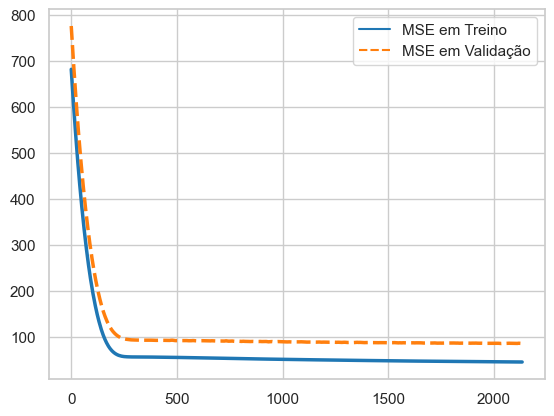

In [12]:
# Gráfico final
sns.set(style = "whitegrid")
sns.lineplot(data = df, palette = "tab10", linewidth  = 2.5)


#### MSE em Treino

###### Valor alto de MSE no início, indicando muitos erros, mas que rapidamente caem bruscamente aproximando-se de uma estabilidade

###### Em seguida, visto que o modelo não mais possui grande aprendizado, o callback encerra o treino bem anteriormente aos 4000 ciclos iniciais



#### MSE em Validação

###### Aqui, os valores utilizados são desconhecidos para o modelo preditivo; a proximidade das duas linhas é um bom sinal.

In [13]:
# Previsões com o modelo treinado
previsoes = modelo.predict(x_teste).flatten()

previsoes


4/4 [==============================] - 0s 2ms/step


array([21.03615  , 18.667273 , 23.908041 , 21.433886 , 20.720297 ,
       20.813883 , 24.492949 , 22.001245 , 21.188227 , 21.001055 ,
       25.785593 , 23.451815 , 21.392942 , 22.779173 , 23.288038 ,
       21.720488 , 26.902765 , 23.381628 , 29.295034 , 20.141237 ,
       20.59162  , 21.13558  , 19.439352 , 21.03615  , 19.217085 ,
       23.5337   , 22.91955  , 14.73085  , 17.526705 , 34.904297 ,
       21.603506 , 18.509348 , 20.188032 , 22.855207 , 31.336363 ,
       24.30578  , 21.90766  , 27.902956 , 25.69201  , 31.979761 ,
       27.487673 , 30.429758 , 31.85108  , 17.526705 , 23.106718 ,
       23.311438 , 18.632181 , 23.574644 , 36.828644 , 35.038826 ,
       18.439161 , 34.448067 , 30.903532 , 25.844084 , 23.662382 ,
       22.855207 , 26.048803 , 27.727484 , 24.697668 , 24.329176 ,
       23.212004 , 19.304823 , 23.440115 , 22.86106  , 21.22917  ,
       20.3986   , 21.357847 , 22.252752 , 21.755583 , 21.667849 ,
       26.955408 , 24.808798 , 11.467068 , 14.461792 , 17.4448